<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/example_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorly
!pip install pot
!git clone https://github.com/zsteve/wtf

     |████████████████████████████████| 112kB 7.1MB/s 
     |████████████████████████████████| 163kB 15.9MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.1-cp37-none-any.whl size=149171 sha256=fdbba371590aed32be73760211935c606964654d7110f8938f0a78937ca8137b
  Stored in directory: /root/.cache/pip/wheels/88/1e/e7/b9677b2046cc87e17931b4b5781941786d3ee647825ca40ea6
Successfully built tensorly
     |████████████████████████████████| 440kB 9.9MB/s 
Cloning into 'wtf'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 38 (delta 14), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [ ]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

PLT_CELL = 2.5
figs_path = "/content/manuscript/figs/"

In [ ]:
import os
import sys
sys.path.insert(0, "/content/wtf/src")
import wtf

(array([  2.,   3.,  25.,  56.,  91., 102.,  63.,  31.,  23.,   4.]),
 array([0.99999985, 0.99999988, 0.9999999 , 0.99999993, 0.99999996,
        0.99999999, 1.00000002, 1.00000005, 1.00000008, 1.00000011,
        1.00000013]),
 <a list of 10 Patch objects>)

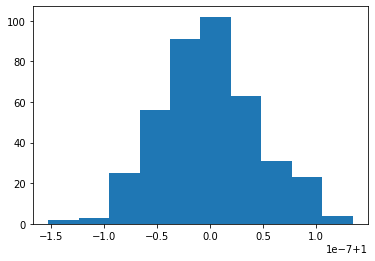

In [ ]:
# load Olivetti faces dataset
# simple image scaling to (nR x nC) size
def scale(im, nR, nC):
  nR0 = len(im)     # source number of rows 
  nC0 = len(im[0])  # source number of columns 
  return [[ im[int(nR0 * r / nR)][int(nC0 * c / nC)]  
             for c in range(nC)] for r in range(nR)]

data = sklearn.datasets.fetch_olivetti_faces()

perm = np.argsort(data.target)
data.target = data.target[perm]
images_rescaled = [np.array(scale(data.images[i, :, :], 32, 32)) for i in range(data.images.shape[0])]
sizex, sizey = (32, 32)
## uncomment for unnormalised
# X = tl.tensor(np.array([i for i in images_rescaled]), dtype = tl_dtype)
# X = X/X.sum(-1).sum(-1).mean()
## normalised
X = tl.tensor(np.array([wtf.normalise(i) for i in images_rescaled]), dtype = tl_dtype)
target = data.target
plt.hist(X.sum(-1).sum(-1))

In [ ]:
# code to subsample randomly
train_idx = (np.arange(len(target)).reshape(40, 10)[:, :5]).reshape(-1)
test_idx = (np.arange(len(target)).reshape(40, 10)[:, 5:]).reshape(-1)
X_train = X[train_idx, :, :]
X_test = X[test_idx, :, :]

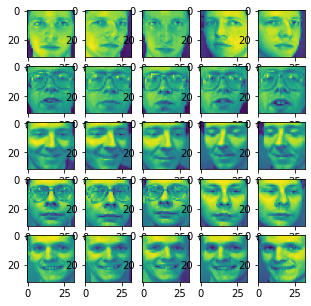

In [ ]:
plt.figure(figsize = (5, 5))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i, :, :])

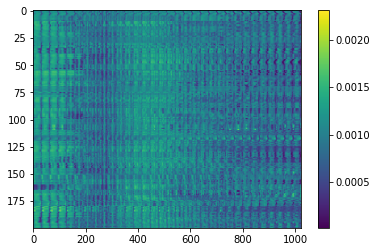

In [ ]:
plt.imshow(tl.unfold(X_train, 0))
plt.axis("auto")
plt.colorbar()

In [ ]:
tl.unfold(X_train, 0).shape

torch.Size([200, 1024])

In [ ]:
xx, yy = np.meshgrid(range(sizex), range(sizey))
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

In [ ]:
# now pick multilinear rank
d = 3
r = [20, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

# initialise using SVD components as done by non_negative_parafac, hence n_iter_max = 0
factor_cp = tl.decomposition.non_negative_parafac(X_train, rank = r[0], n_iter_max = 0, init = "svd")
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0_train = X_train.to(device)

n_iter = 10
lr = np.array([[1, 1, 1], ]*n_iter)*1
lamda = np.array([np.ones(3), ]*n_iter)*25
optim_modes = [0, ]
rho = np.array([[1e-3, 1e-3, 1e-3], ]*n_iter)
eps0, eps1 = 0.001, 0.001
eps = np.array([np.ones(3), ]*n_iter)*eps1
alpha = np.exp(1/(n_iter-1)*np.log(eps1/eps0))
eps[0:n_iter] = np.array([[eps0*(alpha**i), ]*3 for i in range(n_iter)])
eps

array([[0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001],
       [0.001, 0.001, 0.001]])

In [ ]:
max_iter, print_inter, check_iter, unbal = (100, 10, 10, True) 
tol = 1e-3
mode = "lbfgs"
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0")
    m0 = wtf.FactorsModel(X0_train, 0, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m0, lr = lr[i, 0], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_train, 1, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m1, lr = lr[i, 1], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0_train, 2, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m2, lr = lr[i, 2], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A[2] = m2.compute_primal_variable().detach()
    ## uncomment if want to optimise over core tensor for a Tucker decomposition
    # print("Core tensor")
    # m = wtf.CoreModel(X0_train, None, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", C_full = C_full, device = device, unbal = unbal)
    # wtf.solve(m, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    # S = m.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 1.590281
i = 10 	 dual = 1.427449
Mode 1
i = 0 	 dual = 1.848063
i = 10 	 dual = 1.700699
Mode 2
i = 0 	 dual = 1.856181
i = 10 	 dual = 1.740342
Block iteration  1
Mode 0
i = 0 	 dual = 1.633463
i = 10 	 dual = 1.575708
Mode 1
i = 0 	 dual = 1.826166
i = 10 	 dual = 1.803047
Mode 2
i = 0 	 dual = 1.829290
i = 10 	 dual = 1.807993
Block iteration  2
Mode 0
i = 0 	 dual = 1.644533
i = 10 	 dual = 1.607999
Mode 1
i = 0 	 dual = 1.839898
i = 10 	 dual = 1.823982
Mode 2
i = 0 	 dual = 1.839290
i = 10 	 dual = 1.815763
Block iteration  3
Mode 0
i = 0 	 dual = 1.649042
i = 10 	 dual = 1.615023
Mode 1
i = 0 	 dual = 1.844049
i = 10 	 dual = 1.836757
Mode 2
i = 0 	 dual = 1.846665
i = 10 	 dual = 1.840789
Block iteration  4
Mode 0
i = 0 	 dual = 1.650883
i = 10 	 dual = 1.618710
Mode 1
i = 0 	 dual = 1.844925
i = 10 	 dual = 1.839131
Mode 2
i = 0 	 dual = 1.848207
i = 10 	 dual = 1.842749
Block iteration  5
Mode 0
i = 0 	 dual = 1.652206
i = 10 	 dual =

In [ ]:
X_hat = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp = tl.decomposition.non_negative_parafac(X_train, rank = r[0], init = "svd", n_iter_max = 500)
X_cp = tl.cp_tensor.cp_to_tensor(factor_cp)

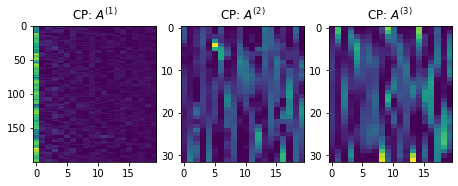

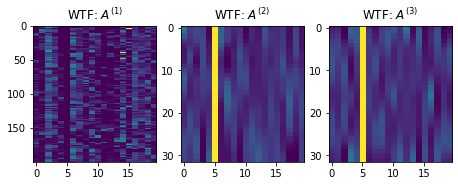

In [ ]:
plt.figure(figsize = (PLT_CELL*3, PLT_CELL))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(factor_cp.factors[i], interpolation = "nearest")
    plt.title("CP: $A^{(%d)}$" % (i+1))
    plt.axis("auto")
# plt.savefig(figs_path + "factors_cp_faces.pdf")

plt.figure(figsize = (PLT_CELL*3, PLT_CELL))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(A[i].cpu(), interpolation = "nearest")
    plt.title("WTF: $A^{(%d)}$" % (i+1))
    plt.axis("auto")
# plt.savefig(figs_path + "factors_wtf_faces.pdf")

In [ ]:
# save factor matrices
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/A0.npy", A[0].cpu())
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/A1.npy", A[1].cpu())
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/A2.npy", A[2].cpu())
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/S.npy", S.cpu())


# np.save("/content/Tensor-project/manuscript/faces/svm_classification/A0_cp.npy", factor_cp.factors[0])
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/A1_cp.npy", factor_cp.factors[1])
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/A2_cp.npy", factor_cp.factors[2])
# 
# # also save label information
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/training_idx.npy", training_idx)
# np.save("/content/Tensor-project/manuscript/faces/svm_classification/test_idx.npy", test_idx)

(-0.5, 399.5, 19.5, -0.5)

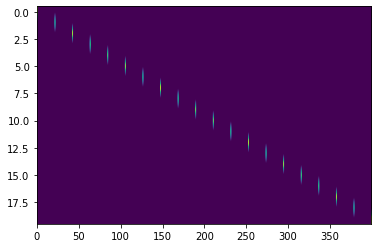

In [ ]:
plt.imshow(tl.unfold(S, 0).cpu())
plt.axis("auto")

(-0.5, 399.5, 1023.5, -0.5)

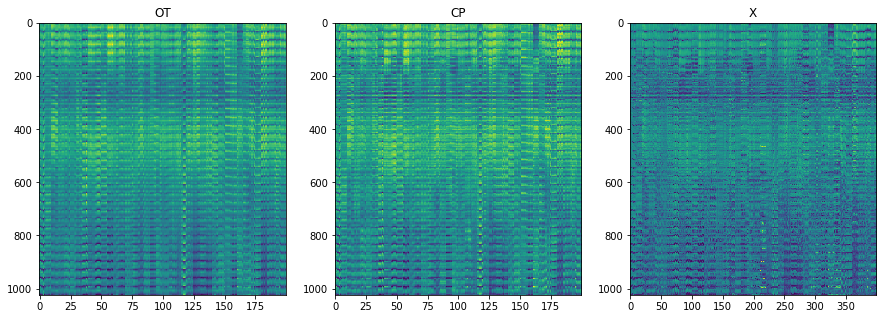

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.title("OT")
plt.imshow(X_hat.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 2)
plt.title("CP")
plt.imshow(X_cp.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 3)
plt.title("X")
plt.imshow(X.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")

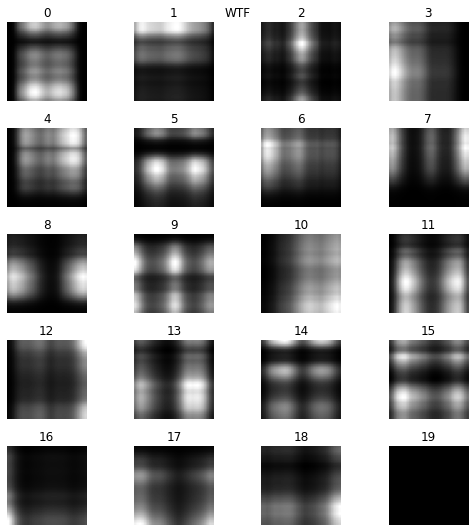

In [ ]:
def outer(u, v):
    return u.reshape(-1, 1) * v.reshape(1, -1)

plt.figure(figsize = (3*PLT_CELL, 3*PLT_CELL))
plt.suptitle("WTF")
perm = np.array(np.argsort(A[0].sum(0).cpu()))[::-1]
for i in range(20): 
    plt.subplot(5, 4, i+1)
    plt.title("%d" % i)
    plt.imshow(outer(A[1][:, perm[i]], A[2][:, perm[i]]).cpu(), cmap = "gray")
    plt.axis("off")
plt.tight_layout()
# plt.savefig(figs_path + "faces_wtf_atoms.pdf")

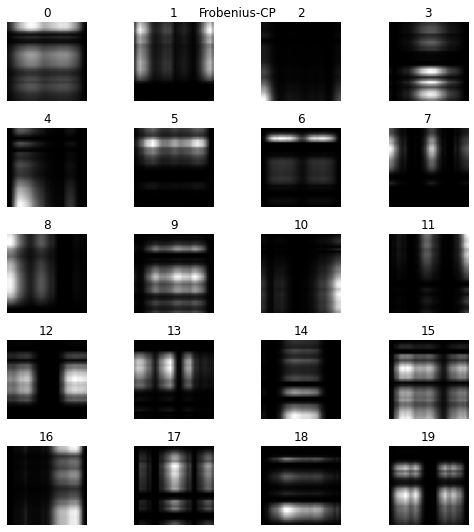

In [ ]:
plt.figure(figsize = (3*PLT_CELL, 3*PLT_CELL))
plt.suptitle("Frobenius-CP")
perm = np.array(np.argsort(factor_cp.factors[0].sum(0)))[::-1]
for i in range(20): 
    plt.subplot(5, 4, i+1)
    plt.title("%d" % i)
    plt.imshow(outer(factor_cp.factors[1][:, perm[i]], factor_cp.factors[2][:, perm[i]]).cpu(), cmap = "gray")
    plt.axis("off")
plt.tight_layout()
# plt.savefig(figs_path + "faces_cp_atoms.pdf")

In [ ]:
# Classification using SVM classifier
# classification using WTF
from sklearn import svm
clf = svm.SVC()
clf.fit(A[0].cpu(), target[train_idx])

# fit new coefficients using learned basis
A_test = [tl.ones((X_test.shape[0], r[0]), dtype = tl_dtype), tl.copy(A[1]), tl.copy(A[2])]
m0 = wtf.FactorsModel(tl.tensor(X_test, dtype = tl_dtype).cuda(), 0, None, S, A_test, rho[-1, :], eps[-1, :], lamda[-1, :], 
                         optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
wtf.solve(m0, lr = 1, mode = "lbfgs", max_iter = 100, print_inter = 10, check_iter = 10, tol = 1e-5)
A_test[0] = m0.compute_primal_variable().detach()
err_train = (clf.predict(A[0].cpu()) != target[train_idx]).mean() # train error
err_test = (clf.predict(A_test[0].cpu()) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

/usr/local/lib/python3.7/dist-packages/tensorly/backend/pytorch_backend.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)


i = 0 	 dual = 1.653788
i = 10 	 dual = 1.624403
err_train =  0.06  err_test =  0.34


In [ ]:
cp_fitter.components_

array([[8.74474199e-03, 1.30161195e-02, 2.08677006e-02, ...,
        2.56394954e-03, 7.71057139e-04, 1.42739239e-04],
       [2.15453899e-02, 2.13156646e-02, 1.66617866e-02, ...,
        6.55593677e-02, 9.98657384e-02, 1.25342633e-01],
       [2.05636932e-03, 4.63967443e-04, 3.78719255e-05, ...,
        4.81700985e-03, 4.03897932e-04, 3.00885369e-06],
       ...,
       [1.99525935e-03, 2.09678582e-03, 1.92419004e-03, ...,
        4.20254516e-05, 4.06708036e-05, 3.96064983e-05],
       [7.42392616e-07, 4.74515803e-05, 4.80444528e-03, ...,
        1.64863962e-01, 3.74111538e-02, 1.81546796e-03],
       [2.64235865e-04, 2.44820822e-03, 6.18448460e-03, ...,
        1.97073917e-02, 3.22574140e-03, 3.79785359e-06]])

In [ ]:
# classification using Frobenius-CP
from sklearn import decomposition
clf_cp = svm.SVC()
clf_cp.fit(factor_cp.factors[0], target[train_idx])
# keep basis fixed, learn coefficients w.r.t. squared Frobenius norm.
# problem is convex (in a single factor), use sklearn.decomposition.NMF to solve for coefficients.
cp_fitter = sklearn.decomposition.NMF() 
cp_fitter.n_components_ = r[0] 
cp_fitter.components_ = np.array(tl.tenalg.khatri_rao(factor_cp.factors[1:])).T
coeffs = cp_fitter.transform(tl.unfold(X_test, 0))
err_train = (clf_cp.predict(factor_cp.factors[0]) != target[train_idx]).mean() # train error
err_test = (clf_cp.predict(coeffs) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.25  err_test =  0.44


In [ ]:
# classification using PCA (breaks the non-negativity constraint)
pca = sklearn.decomposition.PCA(n_components = r[0])
X_train_pca = pca.fit_transform(tl.unfold(X_train, 0))
X_test_pca = pca.transform(tl.unfold(X_test, 0))
clf_pca = svm.SVC()
clf_pca.fit(X_train_pca, target[train_idx])
err_train = (clf_pca.predict(X_train_pca) != target[train_idx]).mean() # train error
err_test = (clf_pca.predict(X_test_pca) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.02  err_test =  0.205


In [ ]:
# Classification using Frobenius-CP basis (but learn coeffs with OT)
A_train = [tl.ones((X_train.shape[0], r[0]), dtype = tl_dtype), tl.copy(factor_cp.factors[1].cuda()), tl.copy(factor_cp.factors[2].cuda())]
# A_train = [tl.ones((X_train.shape[0], r[0]), dtype = tl_dtype), tl.copy(A[1]), tl.copy(A[2])]
m0 = wtf.FactorsModel(tl.tensor(X_train, dtype = tl_dtype).cuda(), 0, None, S, A_train, rho[-1, :], eps[-1, :], lamda[-1, :], 
                         optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
wtf.solve(m0, lr = 1, mode = "lbfgs", max_iter = 100, print_inter = 10, check_iter = 10, tol = 1e-5)
A_train[0] = m0.compute_primal_variable().detach()
clf = svm.SVC()
clf.fit(A_train[0].cpu(), target[train_idx])

A_test = [tl.ones((X_test.shape[0], r[0]), dtype = tl_dtype), tl.copy(factor_cp.factors[1].cuda()), tl.copy(factor_cp.factors[2].cuda())]
# A_test = [tl.ones((X_test.shape[0], r[0]), dtype = tl_dtype), tl.copy(A[1]), tl.copy(A[2])]
m0 = wtf.FactorsModel(tl.tensor(X_test, dtype = tl_dtype).cuda(), 0, None, S, A_test, rho[-1, :], eps[-1, :], lamda[-1, :], 
                         optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
wtf.solve(m0, lr = 1, mode = "lbfgs", max_iter = 100, print_inter = 10, check_iter = 10, tol = 1e-5)
A_test[0] = m0.compute_primal_variable().detach()
err_train = (clf.predict(A_train[0].cpu()) != target[train_idx]).mean() # train error
err_test = (clf.predict(A_test[0].cpu()) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

/usr/local/lib/python3.7/dist-packages/tensorly/backend/pytorch_backend.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)


i = 0 	 dual = 20.417040
i = 10 	 dual = 20.397735
i = 20 	 dual = 20.397707


/usr/local/lib/python3.7/dist-packages/tensorly/backend/pytorch_backend.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)


i = 0 	 dual = 20.420589
i = 10 	 dual = 20.401565
i = 20 	 dual = 20.401553
err_train =  0.23  err_test =  0.435


In [ ]:
d_ot = np.array([ot.emd2(wtf.normalise(X_hat[i, :, :].reshape(-1).double()), wtf.normalise(X_train[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])
d_baseline = np.array([ot.emd2(wtf.normalise(X_cp[i, :, :].reshape(-1).double()), wtf.normalise(X_train[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])

KeyboardInterrupt: ignored

In [ ]:
np.sqrt(d_ot).mean(), np.sqrt(d_baseline).mean()

(0.022668690860137827, 0.020086336637949235)

Text(0, 0.5, 'EMD')

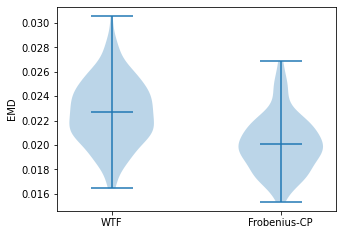

In [ ]:
plt.figure(figsize = (2*PLT_CELL, 1.5*PLT_CELL))
plt.violinplot(np.hstack([np.sqrt(d_ot).reshape(-1, 1), np.sqrt(d_baseline).reshape(-1, 1)]), showmeans = True)
plt.xticks(ticks = [1, 2], labels = ["WTF", "Frobenius-CP"]);
plt.ylabel("EMD")
# plt.savefig(figs_path + "emd_distance_faces.pdf")

In [ ]:
# Unsupervised clustering of the training set (get full dataset by setting X_train = X)
from sklearn import cluster
kmeans = sklearn.cluster.KMeans(n_clusters = 40, n_init = 100)
clust_ot = kmeans.fit_predict(A[0].cpu())
clust_cp = kmeans.fit_predict(factor_cp.factors[0])

In [ ]:
nmi_ot = sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust_ot)
nmi_cp = sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust_cp)
nmi_ot, nmi_cp

(0.7601947830787409, 0.7074005832581791)

In [ ]:
def f():
    kmeans = sklearn.cluster.KMeans(n_clusters = 40, n_init = 100)
    clust_cp = kmeans.fit_predict(factor_cp.factors[0])
    return sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust_cp)

out = np.array([f() for _ in range(10)])

In [ ]:
out.max()

0.7309961228322565

In [ ]:
# now try NMF with the same dataset, learning 10 atoms
r_nmf = [20, ]*2
S_nmf = tl.zeros(r_nmf).to(device)
for i in range(r_nmf[0]):
    S_nmf[i, i] = 1

X0_nmf = tl.unfold(X_train, 0).to(device)
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd", max_iter = 1)
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)

A_nmf = copy.deepcopy([U_nmf, V_nmf.T])
A_nmf = [a.to(device) for a in A_nmf]

In [ ]:
params_nmf = {"n_iter" : 10}
params_nmf['lr'] = np.ones(params_nmf['n_iter'])*1
params_nmf['lamda'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*25
params_nmf['optim_modes'] = [0, ]
params_nmf['rho'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.001
params_nmf['eps'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.001


In [ ]:
max_iter, print_inter, check_iter, unbal = (100, 10, 10, False)
tol = 1e-4
mode = "lbfgs"
for i in range(params_nmf['n_iter']):
    print("Block iteration ", i)
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_nmf, 1, None, S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             params_nmf['optim_modes'], ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m1, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[1] = m1.compute_primal_variable().detach()
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0_nmf, 0, None, S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             params_nmf['optim_modes'], ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m0, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[0] = m0.compute_primal_variable().detach()


Block iteration  0
Mode 1
i = 0 	 dual = 1.664086
i = 10 	 dual = 1.545679
i = 20 	 dual = 1.458055
i = 30 	 dual = 1.384419
i = 40 	 dual = 1.330377
i = 50 	 dual = 1.291555
i = 60 	 dual = 1.274419
i = 70 	 dual = 1.264858
i = 80 	 dual = 1.257162
i = 90 	 dual = 1.240565
Mode 0
i = 0 	 dual = 1.614027
i = 10 	 dual = 1.537284
i = 20 	 dual = 1.498802
i = 30 	 dual = 1.489409
i = 40 	 dual = 1.488700
Block iteration  1
Mode 1
i = 0 	 dual = 1.643419
i = 10 	 dual = 1.582705
i = 20 	 dual = 1.567035
i = 30 	 dual = 1.537571
i = 40 	 dual = 1.470503
i = 50 	 dual = 1.381072
i = 60 	 dual = 1.241778
i = 70 	 dual = 1.038476
i = 80 	 dual = 0.770736
i = 90 	 dual = 0.417220
Mode 0
i = 0 	 dual = 1.296476
i = 10 	 dual = nan
i = 20 	 dual = 1.167749
i = 30 	 dual = 1.098952
i = 40 	 dual = 1.042128
i = 50 	 dual = 0.995169
i = 60 	 dual = 0.959456
i = 70 	 dual = 0.926068
i = 80 	 dual = 0.856142
i = 90 	 dual = 0.768080
Block iteration  2
Mode 1
i = 0 	 dual = 1.654222
i = 10 	 dual = na

In [ ]:
X_hat_nmf = tl.tenalg.multi_mode_dot(S_nmf, A_nmf ).cpu()

nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd")
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)
X_nmf = U_nmf @ V_nmf

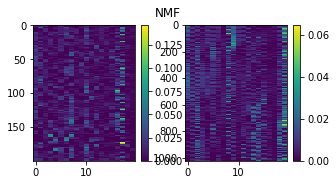

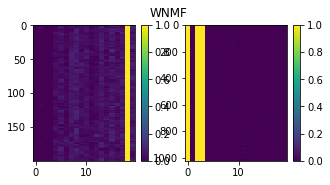

In [ ]:
plt.figure(figsize = (5, 2.5))
plt.suptitle("NMF")
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow([U_nmf, V_nmf.T][i], interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

plt.figure(figsize = (5, 2.5))
plt.suptitle("WNMF")
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(A_nmf[i].cpu(), interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

In [ ]:
from sklearn import cluster
kmeans = sklearn.cluster.KMeans(n_clusters = 40, n_init = 100)
clust_ot = kmeans.fit_predict(A_nmf[0].cpu())
nmi_ot = sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust_ot)
def f():
    clust_cp = kmeans.fit_predict(U_nmf)
    nmi_cp = sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust_cp)
    return nmi_cp

out = np.array([f() for _ in range(10)])

In [ ]:
nmi_ot, out.mean()

(0.7960670284133415, 0.7427399200868405)

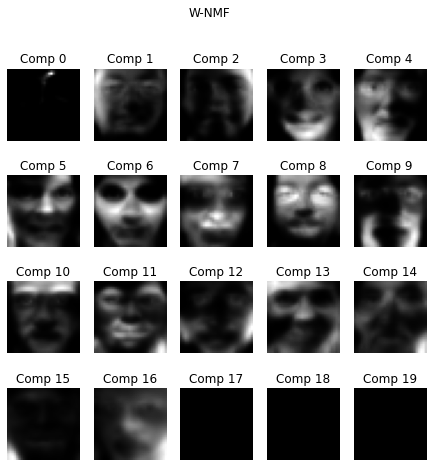

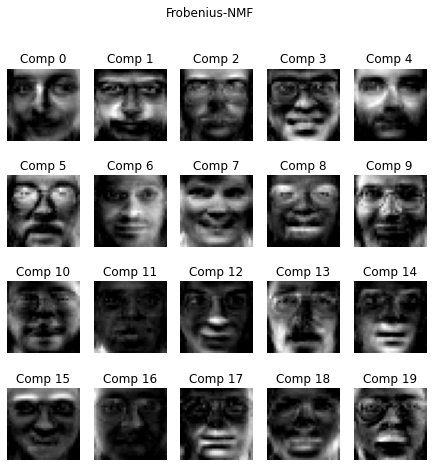

In [ ]:
plt.figure(figsize = (3*PLT_CELL, 3*PLT_CELL))
plt.suptitle("W-NMF")
perm = np.array(np.argsort(A_nmf[0].sum(0).cpu()))[::-1]
for i in range(r_nmf[0]):
    plt.subplot(4, 5, i+1)
    plt.title("Comp %d" % i)
    plt.imshow(A_nmf[1][:, perm[i]].reshape(sizex, sizey).cpu(), cmap = "gray")
    plt.axis("off")
# plt.savefig(figs_path + "faces_wnmf_atoms.pdf")

plt.figure(figsize = (3*PLT_CELL, 3*PLT_CELL))
plt.suptitle("Frobenius-NMF")
perm = np.array(np.argsort(U_nmf.sum(0)))[::-1]
for i in range(r_nmf[0]):
    plt.subplot(4, 5, i+1)
    plt.title("Comp %d" % i)
    plt.imshow(V_nmf[perm[i], :].reshape(sizex, sizey), cmap = "gray")
    plt.axis("off")
# plt.savefig(figs_path + "faces_nmf_atoms.pdf")

In [ ]:
d_ot_nmf = np.array([ot.emd2(wtf.normalise(X_hat_nmf[i, :].reshape(-1).double()), wtf.normalise(X_train[i, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])
d_baseline_nmf = np.array([ot.emd2(wtf.normalise(X_nmf[i, :].reshape(-1).double()), wtf.normalise(X_train[i, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])

Text(0, 0.5, 'EMD')

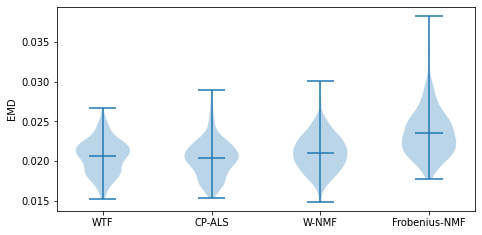

In [ ]:
plt.figure(figsize = (3*PLT_CELL, 1.5*PLT_CELL))
plt.violinplot(np.hstack([np.sqrt(d_ot).reshape(-1, 1), 
                       np.sqrt(d_baseline).reshape(-1, 1),
                       np.sqrt(d_ot_nmf).reshape(-1, 1), 
                       np.sqrt(d_baseline_nmf).reshape(-1, 1)]), showmeans = True)
plt.xticks(ticks = [1, 2, 3, 4], labels = ["WTF", "CP-ALS", "W-NMF", "Frobenius-NMF"]);
plt.ylabel("EMD")
# plt.savefig(figs_path + "emd_distance_faces_full.pdf")

In [ ]:
import sys
size_tot_nmf = np.prod(U_nmf.shape) + np.prod(V_nmf.shape)
size_tot_ntf = np.sum([np.prod(a.shape) for a in A])
size_tot_ntf/size_tot_nmf

0.43137254901960786

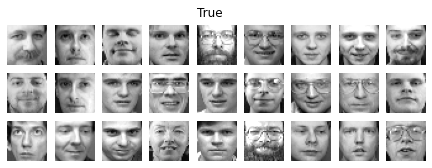

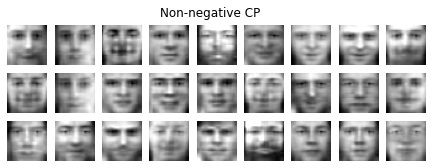

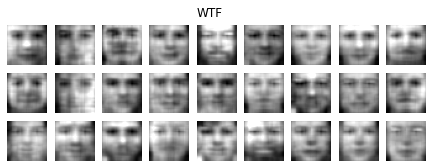

In [ ]:
vmax = np.quantile(X_train, 0.99)

perm = np.random.permutation(np.arange(X_train.shape[0]))

plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("True")
for i in range(27):
    plt.subplot(3, 9, i+1)
    plt.imshow(X_train[perm[i], :].reshape(sizex, sizey), cmap = "gray", vmax = vmax)
    plt.axis("off")
# plt.savefig(figs_path + "faces_true.pdf")

plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("Non-negative CP")
for i in range(27):
    plt.subplot(3, 9, i+1)
    plt.imshow(X_cp[perm[i], :].reshape(sizex, sizey), cmap = "gray", vmax = vmax)
    plt.axis("off")
# plt.savefig(figs_path + "faces_cp.pdf")

plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("WTF")
for i in range(27):
    plt.subplot(3, 9, i+1)
    plt.imshow(X_hat[perm[i], :].reshape(sizex, sizey), cmap = "gray", vmax = vmax)
    plt.axis("off")
# plt.savefig(figs_path + "faces_ot.pdf")

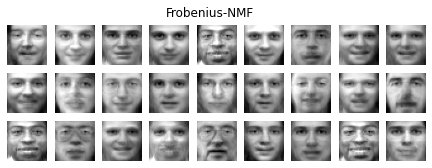

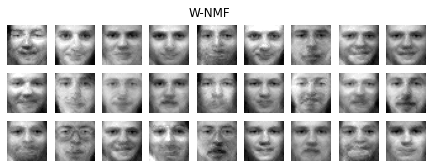

In [ ]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("Frobenius-NMF")
for i in range(27):
    plt.subplot(3, 9, i+1)
    plt.imshow(X_nmf[perm[i], :].reshape(sizex, sizey), cmap = "gray", vmax = vmax)
    plt.axis("off")
# plt.savefig(figs_path + "faces_nmf.pdf")

plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("W-NMF")
for i in range(27):
    plt.subplot(3, 9, i+1)
    plt.imshow(X_hat_nmf[perm[i], :].reshape(sizex, sizey), cmap = "gray", vmax = vmax)
    plt.axis("off")
# plt.savefig(figs_path + "faces_wnmf.pdf")